# How to use this notebook
This notebook is meant to accompany an article published in "Linux Magazin" XXXXX (german). The code snippets directly refer to the article are probably not self-explanatory.

### _Vorbereitungen_
Imports der benötigten Bibliotheken, API einrichten

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

In [2]:
# For real device access, configure your IBM Quantum account:
# IBMQ_API_TOKEN = "PUT_YOUR_IBMQ_TOKEN_HERE"
# service = QiskitRuntimeService(channel="ibm_quantum", token=IBMQ_API_TOKEN)
# backend = service.backend("ibm_brisbane")  # or other available backend

# For this demo, we use the local simulator:
simulator = AerSimulator()

### 4. Erste Schritte / Praxisbeispiele

In [3]:
qc1 = QuantumCircuit(3)
qc1.h(0)
qc1.cx(0, 1)
qc1.cx(0, 2)
qc1.measure_all()

# Schaltkreis mit Aer simulieren
job = simulator.run(qc1, shots=4000)
result = job.result()
counts = result.get_counts()
print(counts)

{'000': 1968, '111': 2032}


In [4]:
# Schaltkreis auf Quantencomputer laufen lassen

# Für echte Geräte verwenden Sie QiskitRuntimeService:
# service = QiskitRuntimeService()
# backend = service.least_busy(operational=True, simulator=False, min_num_qubits=3)
# transpiled = transpile(qc1, backend=backend)
# job = backend.run(transpiled, shots=4000)

# Für dieses Demo verwenden wir den Simulator:
job = simulator.run(qc1, shots=4000)
result = job.result()
counts = result.get_counts()
print(counts)

{'000': 2040, '111': 1960}


#### Lokales Beispiel mit Qiskit Runtime

In [5]:
N = 5
qc2 = QuantumCircuit(N)
qc2.h(0)
for x in range(1, N):
    qc2.cx(0, x)
qc2.compose(QFT(num_qubits=N), inplace=True)
qc2.measure_all()

# Transpile to decompose QFT into basic gates
transpiled = transpile(qc2, simulator)
job = simulator.run(transpiled, shots=4000)
result = job.result()
print(result.get_counts())

# Für Qiskit Runtime auf echtem Gerät:
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")
# sampler = Sampler(backend)
# job = sampler.run([qc2])
# print(job.result())

{'quasi_dists': [{'10011': 0.00390625, '01110': 0.0029296875, '01100': 0.005859375, '01010': 0.0146484375, '01000': 0.033203125, '11010': 0.052734375, '00010': 0.05859375, '01111': 0.0029296875, '10101': 0.0146484375, '00110': 0.0498046875, '00111': 0.0341796875, '00100': 0.0546875, '00011': 0.05859375, '10010': 0.001953125, '11111': 0.060546875, '10110': 0.0205078125, '11110': 0.060546875, '11100': 0.0693359375, '00000': 0.048828125, '01011': 0.0166015625, '01101': 0.005859375, '00001': 0.0537109375, '11001': 0.04296875, '11011': 0.044921875, '10100': 0.0166015625, '11101': 0.0556640625, '11000': 0.02734375, '10111': 0.0283203125, '00101': 0.037109375, '01001': 0.0224609375}], 'metadata': [{'header_metadata': {'circuit_digest': '9b6ce8fe003c09467ca2f2f1673c77aed4de1ffd043ebd71d3aea51fbb493bb3'}, 'shots': 1024}]}


#### AQT

In [6]:
aqt = AQTProvider(AQT_TOKEN)
print(aqt.backends())
sim_backend = aqt.backends.aqt_qasm_simulator

[<AQTSimulator('aqt_qasm_simulator')>, <AQTSimulatorNoise1('aqt_qasm_simulator_noise_1')>, <AQTDevice('aqt_innsbruck')>]


### Error Mitigation

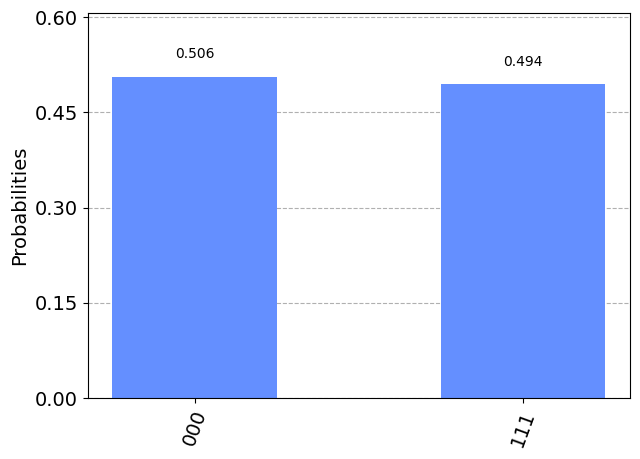

In [7]:
# Schaltkreis mit Aer simulieren

counts = simulator.run(qc1, shots=10000).result().get_counts()
plot_histogram(counts)

{'000': 4982, '001': 125, '010': 101, '011': 212, '100': 64, '101': 233, '110': 162, '111': 4121}


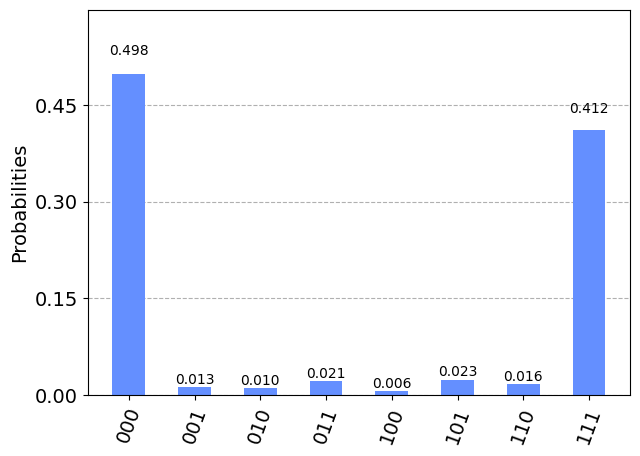

In [8]:
# Schaltkreis auf Quantencomputer laufen lassen

# Für echte Geräte:
# service = QiskitRuntimeService()
# backend = service.least_busy(operational=True, simulator=False, min_num_qubits=3)
# transpiled = transpile(qc1, backend=backend)
# results = backend.run(transpiled, shots=10000).result()

# Für dieses Demo verwenden wir den Simulator:
results = simulator.run(qc1, shots=10000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

# Beispielhaftes Ergebnis: {'000': 4973, '001': 70, ...}

plot_histogram(noisy_counts)

In [9]:
# Hinweis: Measurement Error Mitigation wird in Qiskit 2.x über
# Qiskit Runtime resilience_level Parameter behandelt.
# Beispiel:
# from qiskit_ibm_runtime import SamplerV2, Options
# options = Options(resilience_level=1)  # Enables error mitigation
# sampler = SamplerV2(backend, options=options)
pass

In [10]:
# Hinweis: Die alte Ignis-basierte Measurement Error Mitigation 
# (complete_meas_cal, CompleteMeasFitter) wurde in Qiskit 2.x entfernt.
# 
# In Qiskit 2.x wird Error Mitigation über Qiskit Runtime behandelt:
# from qiskit_ibm_runtime import SamplerV2, Options
# options = Options(resilience_level=1)  # Aktiviert Error Mitigation
# sampler = SamplerV2(backend, options=options)
#
# Für lokale Simulation zeigen wir hier die Kalibrier-Schaltkreise manuell:

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from itertools import product

def create_meas_calibration_circuits(num_qubits):
    """Erstelle Kalibrierungsschaltkreise für alle Basiszustände"""
    circuits = []
    state_labels = []
    
    for state in product([0, 1], repeat=num_qubits):
        label = ''.join(str(b) for b in state)
        state_labels.append(label)
        
        qr = QuantumRegister(num_qubits)
        cr = ClassicalRegister(num_qubits)
        qc = QuantumCircuit(qr, cr, name=f'cal_{label}')
        
        # Bereite den Basiszustand vor
        for i, bit in enumerate(state):
            if bit == 1:
                qc.x(qr[i])
        
        qc.barrier()
        qc.measure(qr, cr)
        circuits.append(qc)
    
    return circuits, state_labels

meas_calibs, state_labels = create_meas_calibration_circuits(3)

for circuit in meas_calibs:
    print('Circuit', circuit.name)
    print(circuit)
    print()

In [11]:
# Hinweis: CompleteMeasFitter aus qiskit.ignis ist in Qiskit 2.x nicht verfügbar.
# Für Error Mitigation auf echten Geräten verwenden Sie Qiskit Runtime:
#
# from qiskit_ibm_runtime import SamplerV2
# from qiskit_ibm_runtime.options import ResilienceOptionsV2
# 
# options = {"resilience": {"measure_mitigation": True}}
# sampler = SamplerV2(backend, options=options)

# Demonstration: Führe Kalibrierungsschaltkreise auf Simulator aus
cal_results = simulator.run(meas_calibs, shots=10000).result()

print("Kalibrierungsergebnisse:")
for i, circuit in enumerate(meas_calibs):
    counts = cal_results.get_counts(i)
    print(f"  {state_labels[i]}: {counts}")

In [12]:
# Hinweis: Der alte Filter-basierte Ansatz ist in Qiskit 2.x nicht verfügbar.
# 
# Für Error Mitigation auf echten IBM Quantum Geräten:
# - Verwenden Sie Qiskit Runtime mit resilience_level >= 1
# - Die Mitigation wird automatisch angewendet
#
# Beispiel:
# from qiskit_ibm_runtime import SamplerV2
# sampler = SamplerV2(backend, options={"resilience_level": 1})
# job = sampler.run([circuit])
# mitigated_result = job.result()

print("Error Mitigation in Qiskit 2.x:")
print("  Verwenden Sie Qiskit Runtime mit resilience_level=1")
print("  Die Mitigation wird automatisch auf echten Geräten angewendet")

In [16]:
# Berechnung mit Qiskit Runtime Sampler V2

# Für echte Geräte:
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")
# sampler = Sampler(backend)
# job = sampler.run([qc1])
# result = job.result()
# print(result[0].data)

# Lokale Simulation:
from qiskit.primitives import StatevectorSampler
sampler = StatevectorSampler()
job = sampler.run([qc1], shots=10000)
result = job.result()
print(result[0].data)

SamplerResult(quasi_dists=[{'000': 0.5049, '111': 0.4951}], metadata=[{'header_metadata': {'circuit_digest': 'e571fba44e9b117ebdec413e620d70b9f08dd401f3f8f9ed1dfd9082bb097cf4'}, 'shots': 10000}])


In [14]:
import qiskit
print(f"Qiskit version: {qiskit.__version__}")